# Dog Breed classification 🐕
This notebook builds a multi-class dog breed image classifier with TensorFlow 2.7 and TensorFlow Hub .12.

## Problem

Determine the breed of a dog from an image.

Customers want a simple alternative for identifying the breed of their dog.

## Data 

The data is a small subset from Kaggle's "Dog Breed Identification": https://www.kaggle.com/c/dog-breed-identification/overview.

There are 3 labeled dog breeds instead of 120 for right now.

## Evaluation 

The evaluation is a file with prediction probablilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## Features

The data has 60 images in the training set and 60 in the test set of about 6 different dog breeds.


# Git

In [33]:
from google.colab import drive
drive.mount('/content/drive')


%cd /content/drive/MyDrive/BreedIdentifier/breedidentifier
%ls -a

!git config --global user.email "madbrow007@gmail.com"
!git config --global user.name {username}

#!git status
#!git reset
#!git remote remove origin 
#!git remote add origin 
#!git remote -v

#!git pull origin master

!git add .
!git commit -m "Added custom image functions"

!git push origin master


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/BreedIdentifier/breedidentifier
BreedIdentifier.ipynb  models/                    new_train/
.git/                  new_labels.csv             README.md
.ipynb_checkpoints/    new_sample_submission.csv  test_predictions_array.csv
logs/                  new_test/
[master 74f8d7a] Added custom image functions
 13 files changed, 61 insertions(+), 50 deletions(-)
 rewrite BreedIdentifier.ipynb (94%)
 create mode 100644 logs/03082022-2227/train/events.out.tfevents.1646778451.9309ba0832ad.77.0.v2
 create mode 100644 logs/03082022-2227/validation/events.out.tfevents.1646778472.9309ba0832ad.77.1.v2
 create mode 100644 logs/03082022-2250/train/events.out.tfevents.1646779805.9309ba0832ad.77.2.v2
 create mode 100644 logs/03092022-1559/train/events.out.tfevents.1646841557.15d6e8b1b533.78.0.v2
 create mode 100644 logs/03092022-1559/validation/events

# Setting up environment

In [2]:
# TensorFlow 2.7 and TensorFlow Hub import
import tensorflow as tf
import tensorflow_hub as hub

# Transforming the data (images) into tensors!

In [3]:
import pandas as pd
#viewing labels

image_labels = pd.read_csv("/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_labels.csv")
print(image_labels.describe())
print(image_labels.head())

                                      id       breed
count                                 60          60
unique                                60           3
top     087b211f15ad8095ba90c0be54c1c30d  great_dane
freq                                   1          20
                                 id              breed
0  087b211f15ad8095ba90c0be54c1c30d         great_dane
1  058ea5b467d08ed978658dc1ad85fb7d        maltese_dog
2  07bbf36ce2c7407751219804b3d187ec  yorkshire_terrier
3  0b86485ef980b0b4999e7ede1f90999e         great_dane
4  022b34fd8734b39995a9f38a4f3e7b6b        maltese_dog


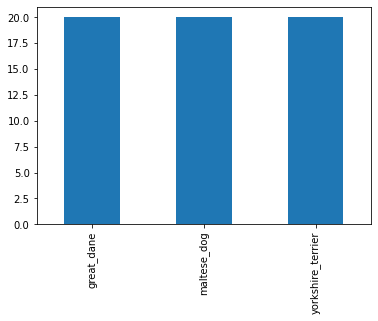

In [4]:
#viewing amount of images per breed on a bar graph
image_labels["breed"].value_counts().plot.bar()

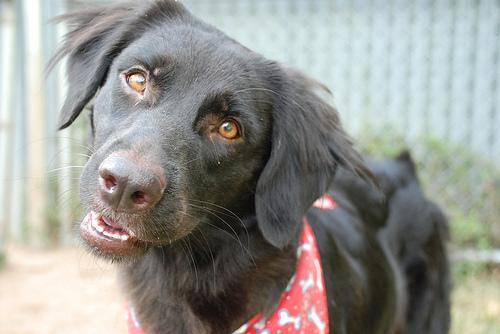

In [5]:
#viewing images

from IPython.display import Image
Image("/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_test/0a342feb5c2100a12bcd15326cf266c6.jpg")

## Listing the images and their labels!

In [6]:
import numpy as np
#Filename id list "filenames"
image_paths = ["/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/" + fname  + ".jpg"  for fname in image_labels["id"]]

labels = image_labels["breed"]
labels = np.array(labels)

#boolean array/ boolean array as integer
unique_labels = np.unique(labels)
labels[0] == unique_labels

boolean_labels = [label == unique_labels for label in labels]



[array([ True, False, False]), array([False,  True, False])]

# Preprocessing image function!

In [7]:
# image to NumPy array
from matplotlib.pyplot import imread
IMAGE_SIZE = 224

# For preprocessing each image
def preprocess_image(image_path, image_size = IMAGE_SIZE):
  """
  Reads in image file and converts it to a tensor
  """

  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[image_size, image_size])

  return image

# print(preprocess_image(image_paths[2]))

# Create batches function!

In [29]:
# Recommended batch size is under 32
BATCH_SIZE = 32

def create_batches(x, y = None, batch_size = BATCH_SIZE, test_data = False, validation_data = False, custom_data = False):
  """
  Creates data batches in sizes of 32 by turning the data to tensor data sets and
  shuffling if training data.
  """

  # test data
  if test_data:
    print(tf.constant(x))
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = dataset.map(preprocess_image).batch(BATCH_SIZE)

    print("data batch created for TEST data!")

  # cusotm data
  elif custom_data:
    print(tf.constant(x))
    dataset = tf.data.Dataset.from_tensor_slices(tf.constant(x, shape = 1))
    data_batch = dataset.map(preprocess_image).batch(BATCH_SIZE)

    print("data batch created for CUSTOM data!")


  # validation data
  elif validation_data:
    print(tf.constant(x))
    print(tf.constant(y))
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = dataset.map(get_image_tuple).batch(BATCH_SIZE)

    print("data batch created for VALIDATION data!")


  # training data
  else:
    dataset = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    dataset = dataset.shuffle(buffer_size=len(x))
    dataset = dataset.map(get_image_tuple)

    data_batch = dataset.batch(BATCH_SIZE)

    print("data batch created for TRAINING data!")

  return data_batch



#train_data = create_batches(x_train, y_train)
#validation_data = create_batches(x_val, y_val, validation_data =True)


#Validation  Set

In [7]:
# file paths to the images
x = image_paths
# boolean numpy label(fileid/breed) representation
y = boolean_labels

# "num_images"
IMAGE_SUBSET = 50 #@param {type:"slider", min:10, max:60, step:5}

In [8]:
from sklearn.model_selection import train_test_split


x_train, x_val, y_train, y_val = train_test_split(x[:IMAGE_SUBSET], y[:IMAGE_SUBSET], test_size=0.2, random_state=0)

# x are images and y are labels
len(x_train), len(x_val), len(y_train), len(y_val)

(40, 10, 40, 10)

In [9]:
x_train[:5], y_train[:5]

(['/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/33ca93ae41a388e66586a7795fef8650.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/23418e1e584a9ac9e51c1ab2c804c1a7.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/1548eb783093ac6bdf011d07f3370a36.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/2071036a0cb133584c9b917b1a7e90d7.jpg',
  '/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/21eec2cb15c5b4948605bf5d2c9ab87e.jpg'],
 [array([ True, False, False]),
  array([False, False,  True]),
  array([False, False,  True]),
  array([False,  True, False]),
  array([ True, False, False])])

## Get tuple function

In [11]:
def get_image_tuple(image_path, label):
  """
  returns a tuple with a processed image and a label
  """
  image = preprocess_image(image_path)
  return image, label


## Visualize data batches function

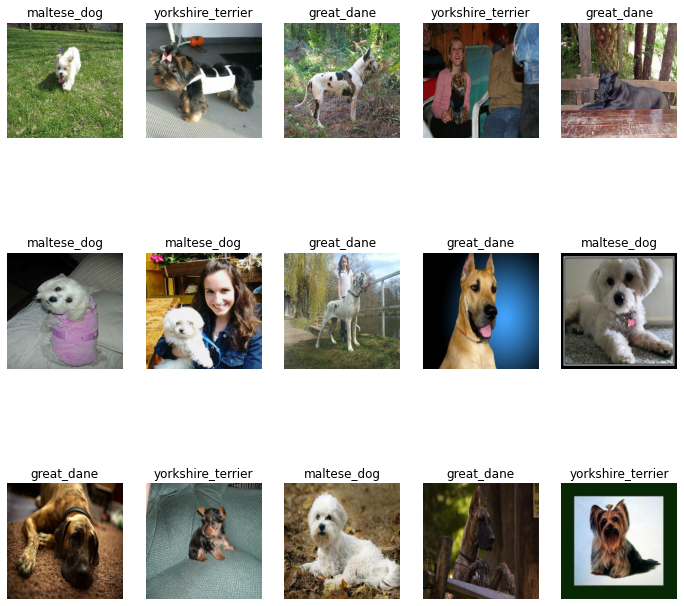

In [13]:
import matplotlib.pyplot as plt

def view_data_batch(images, labels):
  """
  Shows a data batch of images and the labels
  """
  plt.figure(figsize=(12, 12))

  for i in range(15):
    # cretaes 3 rows and 5 columns
    axes = plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(unique_labels[labels[i].argmax()])
    plt.axis("off")

#unbatched the data and turned it into a numpy iterator
x_train, y_train = next(train_data.as_numpy_iterator())

view_data_batch(x_train, y_train)

# Building the model

## Model Setup

In [14]:
# Instantiating the model's input, output, and URL

INPUT_SHAPE = [None, IMAGE_SIZE, IMAGE_SIZE, 3]
OUTPUT_SHAPE = len(unique_labels)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

## Create Model Function 

In [15]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):

  # model layer creation 
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                                                     activation="softmax")
  ])   

  # model compilation 
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # model building
  model.build(INPUT_SHAPE)

  return model                      
                               

## Model Callbacks

In [16]:
%load_ext tensorboard

import datetime
import os

# tensorboard callback
def create_tb_callback():

  log_path = os.path.join("/content/drive/MyDrive/BreedIdentifier/breedidentifier/logs",
                          datetime.datetime.now().strftime("%m%d%Y-%H%M"))
  
  return tf.keras.callbacks.TensorBoard(log_path)

# prevent overfitting with early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

# Training the model

In [17]:
# Epoch variable
EPOCHS = 9

In [18]:
def train_model():
  """
  Returns a trained model
  """

  model = create_model()

  # New tensorboard log each time the model is trained 
  tb = create_tb_callback()

  model.fit(x=train_data,
            epochs=EPOCHS,
            validation_data=validation_data,
            validation_freq=1,
            callbacks=[tb, early_stopping])
  
  return model

In [19]:
model = train_model()

Epoch 1/9
2/2 [==============================] - 19s 4s/step - loss: 1.8142 - accuracy: 0.3000 - val_loss: 1.1745 - val_accuracy: 0.4000
Epoch 2/9
2/2 [==============================] - 0s 213ms/step - loss: 1.2149 - accuracy: 0.4250 - val_loss: 0.8469 - val_accuracy: 0.5000
Epoch 3/9
2/2 [==============================] - 1s 235ms/step - loss: 0.8096 - accuracy: 0.7500 - val_loss: 0.5559 - val_accuracy: 0.8000
Epoch 4/9
2/2 [==============================] - 1s 233ms/step - loss: 0.5323 - accuracy: 0.8750 - val_loss: 0.3422 - val_accuracy: 0.9000
Epoch 5/9
2/2 [==============================] - 1s 299ms/step - loss: 0.3338 - accuracy: 0.9500 - val_loss: 0.2131 - val_accuracy: 1.0000
Epoch 6/9
2/2 [==============================] - 1s 254ms/step - loss: 0.2201 - accuracy: 0.9750 - val_loss: 0.1376 - val_accuracy: 1.0000
Epoch 7/9
2/2 [==============================] - 1s 260ms/step - loss: 0.1473 - accuracy: 0.9750 - val_loss: 0.0944 - val_accuracy: 1.0000
Epoch 8/9
2/2 [==============

# Evaluating the model!

## Accuracy, loss, etc. tensorboard evaluations

In [8]:
# %tensorboard --logdir /content/drive/MyDrive/BreedIdentifier/breedidentifier/logs

## Predictions!

In [9]:
# predicts = model.predict(validation_data)

In [10]:
def get_prediction_breed(predict_probabilities):

  return unique_labels[np.argmax(predict_probabilities)]

In [11]:
def unbatch_data(batched_data):
  pics = []
  breed_labels = []

  unbatched_data = batched_data.unbatch().as_numpy_iterator()

  for pic, breed_label in unbatched_data:
    pics.append(pic)
    breed_labels.append(unique_labels[np.argmax(breed_label)])

  return pics, breed_labels

In [12]:
def unbatch_custom_data(batched_custom_data):
  custom_pics = []
  
  unbatched_custom_data = batched_custom_data.unbatch().as_numpy_iterator()

  for pic in unbatched_custom_data:
    custom_pics.append(pic)

  return custom_pics

In [13]:
def show_top_prediction_comparison(predict_probs, breed_labels, pics, index):

    predict_prob, real_breed_label, pic = predict_probs[index], breed_labels[index], pics[index]

    # prediction label
    predict_label = get_prediction_breed(predict_prob)

    # Plotted pic set up
    fig = plt.figure()
    plt.imshow(pic)
    plt.xticks([])
    plt.yticks([])

    if predict_label == real_breed_label:
        prediction_result_color = "green"
    else:
        prediction_result_color = "red"

   
    fig.suptitle(f"Correct Breed: {real_breed_label}", fontsize=14, fontweight='bold')
    plt.title("Predicted Breed: {} with {:2.0f}% probability of prediction".format(predict_label,
                                                                                   np.max(predict_prob*100)),
                                                                                   color = prediction_result_color)
    

In [14]:
# val_images, val_labels = unbatch_data(validation_data)
# print(val_images)
# show_top_prediction_comparison(predicts, val_labels, val_images, 8)

In [15]:
def show_all_prediction_results(predict_probs, breed_labels, index):

    predict_prob, real_breed_label = predict_probs[index], breed_labels[index]

    ordered_predict_indexes = predict_prob.argsort()[-3:][::-1]
    ordered_predict_vals = predict_prob[ordered_predict_indexes]
    ordered_predict_labels = unique_labels[ordered_predict_indexes]
    
    explode = (0.1, 0, 0)  # explodes top breed
    colors = plt.get_cmap('copper')(np.linspace(0.2, 0.7, 3))
    
    confidence_chart = plt.pie(ordered_predict_vals, explode=explode, labels=ordered_predict_labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops=dict(fontsize="13"))
    
    plt.axis('equal') 

    plt.title("Breed Confidences percentages", fontweight="bold", fontsize=15)

In [16]:
# show_all_prediction_results(predicts, val_labels, 8)

# Saving and unloading!

In [17]:
from time import strftime
def save_a_model(unsaved_model, model_info=None):
  model_path = os.path.join("/content/drive/MyDrive/BreedIdentifier/breedidentifier/models",
                                 datetime.datetime.now().strftime("%m%d%y-%H%M")) + "-" + model_info + ".h5"

  unsaved_model.save(model_path)
 
  return model_path

In [18]:
def load_a_model(model_path):

  model_to_load = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})

  return model_to_load

In [19]:
# save_model(model, model_info="40-images-mobilenetv2")

In [20]:
# Training the full dataset (60 images)

In [21]:
# putting all the data in batches

# complete_data_batches = create_batches(x, y)

# model creation

# complete_model = create_model()

# callbacks for viewing

# complete_model_tb = create_tb_callback()
# complete_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [22]:
# model fitting 
# complete_model.fit(x=complete_data_batches,
#                    epochs = EPOCHS,
#                    callbacks = [complete_model_tb, complete_model_early_stopping])


In [23]:
# save_a_model(complete_model, model_info="60-images-mobilenetv2")

# Load full model!

In [24]:
model_3_8_22 = load_a_model("/content/drive/MyDrive/BreedIdentifier/breedidentifier/models/030822-2252-60-images-mobilenetv2.h5")

# Test data functions

## Model predictions from test data

In [68]:
# removes the .ipynb_checkpoints dir that appears in test_data folder, run each time
# %rm -r .ipynb_checkpoints/
# %ls -la

In [69]:
test_data_dir = "/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_test/"
test_data_paths = [test_data_dir + filepath for filepath in os.listdir(test_data_dir)]

test_data_batches = create_batches(test_data_paths, test_data = True)

test_data_predicts = model_3_8_22.predict(test_data_batches, verbose = 1)

data batch created for TEST data!
2/2 [==============================] - 8s 4s/step


## Save / Load predictions from full test **data**

In [70]:
# np.savetxt("/content/drive/MyDrive/BreedIdentifier/breedidentifier/test_predictions_array.csv",
          #  test_data_predicts, delimiter=",")

In [71]:
complete_test_data_predicts = np.loadtxt("/content/drive/MyDrive/BreedIdentifier/breedidentifier/test_predictions_array.csv",
                                         delimiter=",")

## Test Predictions Array Setup

In [72]:
test_predicts_df = pd.DataFrame(columns = ["image_id"] + list(unique_labels))

test_data_image_ids = [os.path.splitext(path)[0] for path in os.listdir("/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_test")]

test_predicts_df["image_id"] = test_data_image_ids
test_predicts_df[list(unique_labels)] = complete_test_data_predicts

test_predicts_df

,image_id,great_dane,maltese_dog,yorkshire_terrier
0,00e71e327e114433191f34054c6bf6f5,0.027332,0.776676,0.195993
1,00a3edd22dc7859c487a64777fc8d093,0.327499,0.018251,0.654251
2,0a342feb5c2100a12bcd15326cf266c6,0.459052,0.093733,0.447214
3,0a859b76a52d4fac456653a1d45ddf3d,0.620413,0.085757,0.293830
4,0a3f1f6f5f0ede7ea6e27427994d5f62,0.048585,0.733841,0.217575
5,0a4ef19459cd2100977b052de5f46231,0.003665,0.005717,0.990617
6,0bb4e3868bcbe0da6779f8fdf3ed3e92,0.447931,0.075433,0.476636
7,9cbdcc4ff6fc0daf8e32caa3ca818aef,0.981945,0.014186,0.003870
8,9dece95cba6069a919447dfbb19f75e2,0.966376,0.032042,0.001582
9,9f70486e63ac01868d87763df94226ec,0.988553,0.002517,0.008930


# Custom Image setup

In [25]:
def custom_image_prediction(custom_image_filename):

  # batching data
  custom_image_batched = create_batches(custom_image_filename, custom_data = True)

 
  custom_image_predictions = model_3_8_22.predict(custom_image_batched)
  
  custom_image_prediction_label = [get_prediction_breed(custom_image_predictions)]
  
  return custom_image_predictions, custom_image_prediction_label


In [26]:
import matplotlib.pyplot as plt

def show_top_custom_prediction(predict_probs, predicted_breed_label, pic):

    processed_pic = preprocess_image(pic)
    # Plotted pic set up
    fig = plt.figure()
    plt.imshow(processed_pic)
    plt.xticks([])
    plt.yticks([])

    plt.title("Predicted Breed: {} with {:2.0f}% probability of prediction".format(predicted_breed_label,
                                                                                   np.max(predict_probs*100)),
              fontweight="bold", fontsize=15)

In [27]:
def show_custom_prediction_pie(predict_probs):

    ordered_predict_indexes = predict_probs.argsort()[-3:][::-1]
    ordered_predict_vals = predict_probs[ordered_predict_indexes]
    ordered_predict_labels = unique_labels[ordered_predict_indexes]

    fig2 = plt.figure()
    
    explode = (0.1, 0, 0)  # explodes top breed
    colors = plt.get_cmap('copper')(np.linspace(0.2, 0.7, 3))
    
    confidence_chart = plt.pie(ordered_predict_vals, explode=explode, labels=ordered_predict_labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, textprops=dict(fontsize="13"))
    
    plt.axis('equal') 

    plt.title("Breed Confidences percentages", fontweight="bold", fontsize=15)

# Users start here, start_prediction(image) function. Returns predictions in a readable format

In [2]:
def start_prediction(custom_image_path):

  #imports
  from google.colab import drive
  drive.mount('/content/drive')
  import matplotlib.pyplot as plt
  from matplotlib.pyplot import imread
  import tensorflow as tf
  import tensorflow_hub as hub
  import pandas as pd

  # loading model and labels
  model_3_8_22 = load_a_model("/content/drive/MyDrive/BreedIdentifier/breedidentifier/models/030822-2252-60-images-mobilenetv2.h5")

  image_labels = pd.read_csv("/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_labels.csv")
  image_paths = ["/content/drive/MyDrive/BreedIdentifier/breedidentifier/new_train/" + fname  + ".jpg"  for fname in image_labels["id"]]
  labels = image_labels["breed"]
  labels = np.array(labels)
  unique_labels = np.unique(labels)

 
  custom_pred, custom_pred_label = custom_image_prediction(custom_image_path)

  show_top_custom_prediction(custom_pred, custom_pred_label, custom_image_path)

  show_custom_prediction_pie(custom_pred[0])

In [3]:
start_prediction("/content/drive/MyDrive/IMG-7744.jpg")

Mounted at /content/drive


NameError: ignored